In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/github-bugs-prediction-challenge-machine-hack/embold_train_extra.json
/kaggle/input/github-bugs-prediction-challenge-machine-hack/embold_test.json
/kaggle/input/github-bugs-prediction-challenge-machine-hack/embold_train.json
/kaggle/input/github-bugs-prediction-challenge-machine-hack/sample submission.csv


In [2]:
train = pd.read_json('../input/github-bugs-prediction-challenge-machine-hack/embold_train.json')
test = pd.read_json('../input/github-bugs-prediction-challenge-machine-hack/embold_test.json')
train_extra =pd.read_json('../input/github-bugs-prediction-challenge-machine-hack/embold_train_extra.json')

In [3]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [4]:
print(train.shape)
print(train_extra.shape)
print(test.shape)

(150000, 3)
(300000, 3)
(30000, 2)


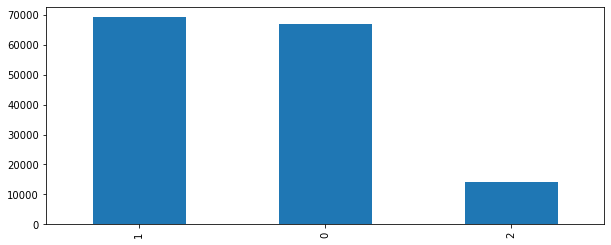

In [5]:

plt.figure(figsize=(10,4))
train.label.value_counts().plot(kind='bar');

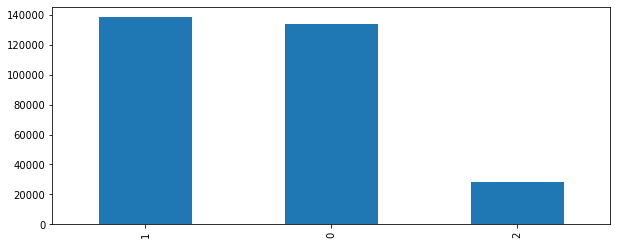

In [6]:
plt.figure(figsize=(10,4))
train_extra.label.value_counts().plot(kind='bar');

In [7]:
train_extra2 = train_extra.loc[train_extra['label'] == 2]

In [8]:
train_extra.head()

,title,body,label
0,use a 8bit typeface,since this is meant to emulate some old arcade...,1
1,implement wireless m-bus binding,_from chris.pa...@googlemail.com https://cod...,1
2,add multilang support for timeago.js,currently it is only en . \r required to add ...,1
3,scaleway - seg-fault on shutdown,tbr irc creates a new scaleway instance with...,0
4,sistema de pintura: no se guardar los nuevos p...,este sp ya estaba asignado a un carro y se enc...,0


In [9]:
train_extra.shape

(300000, 3)

In [10]:
train.tail()

,title,body,label
149995,suggestion getinventorylist should return ra...,<!-- note: anything within these brackets will...,1
149996,decoder displays some neurovault images incorr...,"as noted by @nicholst, some neurovault images ...",0
149997,"parser should return an error, not an exception",for this raml:\r \r yaml\r %raml 1.0\r tit...,0
149998,errorexception array to string conversion on ...,see above.\r \r occurs in branch routes .,0
149999,ignore headings in code sections,do not process headings inside quotes and code...,0


In [11]:
train_extra.tail()

,title,body,label
299995,shield against invalid dates,makes'em crash the renderer for now :|\r \r da...,0
299996,fix the knight,"seriously, if you do just one thing this week...",0
299997,"portaudio playback binding crashes often, ubun...",appear to be very unstable. relates to 17,0
299998,add --db-path option for allowing user to spec...,add --db-path option with default value as ...,1
299999,staff users cannot log in to admin,i added admire as a staff user but he cannot l...,0


In [12]:
frames = [train,train_extra]
train_new = pd.concat([train,train_extra],ignore_index=True)

In [13]:
train_new.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [14]:
train_new.tail()

,title,body,label
449995,shield against invalid dates,makes'em crash the renderer for now :|\r \r da...,0
449996,fix the knight,"seriously, if you do just one thing this week...",0
449997,"portaudio playback binding crashes often, ubun...",appear to be very unstable. relates to 17,0
449998,add --db-path option for allowing user to spec...,add --db-path option with default value as ...,1
449999,staff users cannot log in to admin,i added admire as a staff user but he cannot l...,0


In [15]:
train_new.shape

(450000, 3)

In [16]:
train_new

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0
...,...,...,...
449995,shield against invalid dates,makes'em crash the renderer for now :|\r \r da...,0
449996,fix the knight,"seriously, if you do just one thing this week...",0
449997,"portaudio playback binding crashes often, ubun...",appear to be very unstable. relates to 17,0
449998,add --db-path option for allowing user to spec...,add --db-path option with default value as ...,1


In [17]:
train_new.label.value_counts()

1    207318
0    200481
2     42201
Name: label, dtype: int64

In [18]:
y = train_new.label

In [19]:
y.head()

0    1
1    0
2    1
3    1
4    0
Name: label, dtype: int64

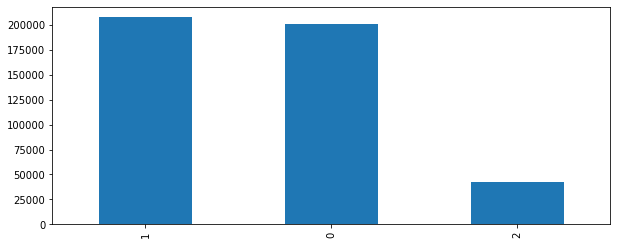

In [20]:
plt.figure(figsize=(10,4))
train_new.label.value_counts().plot(kind='bar');

In [21]:
def print_plot(index):
    example = train_new[train_new.index == index][['title', 'body', "label"]].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print_plot(10)

launcher: check results against training data
Tag: we want to be able to run a suite of algorithms against training data that has been split into training and validation sets, then we want to be able to see the potential results we will get. this task comprises that whole pipeline.


In [22]:
print_plot(30)


step panics if source file isn't found in .debug_line
Tag: please answer the following before submitting your issue:\r \r note: please include any substantial examples  debug session output,\r stacktraces, etc  as linked gists.\r \r 1. what version of delve are you using   dlv version  ? the latest one from the master.\r 2. what version of go are you using?   go version  ? 1.7.1\r 3. what operating system and processor architecture are you using?\r 4. what did you do?\r \r    go\r package main\r \r import \ fmt\ \r \r func main   {\r \tfmt.println \ adssd\   // put a breakpoint here\r }\r    \r \r and step into until you'll get the exception.\r \r 5. what did you expect to see?\r \r 6. what did you see instead?\r \r    \r panic: runtime error: invalid memory address or nil pointer dereference\r  signal sigsegv: segmentation violation code=0x1 addr=0x28 pc=0x42caf41 \r \r goroutine 43  running :\r panic 0x44a8000, 0xc4200140a0 \r \t/users/builduser/buildagent/work/d46533bce70e485f/go/sr

**Text Pre-processing**

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
train_new['title'] = train_new['title'].apply(clean_text)
train_new['body'] = train_new['body'].apply(clean_text)

print_plot(10)

launcher check results against training data
Tag: we want to be able to run a suite of algorithms against training data that has been split into training and validation sets  then we want to be able to see the potential results we will get this task comprises that whole pipeline


In [24]:
print_plot(30)

step panics if source file isnt found in debug_line
Tag: please answer the following before submitting your issuer r note please include any substantial examples  debug session output r stacktraces  etc  as linked gistsr r 1 what version of delve are you using   dlv version   the latest one from the masterr 2 what version of go are you using   go version   171r 3 what operating system and processor architecture are you usingr 4 what did you dor r    gor package mainr r import  fmt r r func main    r tfmtprintln  adssd      put a breakpoint herer  r    r r and step into until youll get the exceptionr r 5 what did you expect to seer r 6 what did you see insteadr r    r panic runtime error invalid memory address or nil pointer dereferencer  signal sigsegv segmentation violation code0x1 addr0x28 pc0x42caf41 r r goroutine 43  running r panic 0x44a8000  0xc4200140a0 r t users builduser buildagent work d46533bce70e485f go src runtime panicgo500 +0x1a1r githubcom derekparker delve dwarf line  

In [25]:
train_new

,title,body,label
0,yzoom piano roll,a yzoom on the piano roll would be useful,1
1,buggy behavior in selection,screenshot from 20160223 21 27 40 https clo...,0
2,auto update feature,hi r r great job so far saenzramiro r r an...,1
3,filter out noisy endpoints in logs,i think we should stop logging requests tor ...,1
4,enable pid on pid off alarm actions for ardu...,expected behaviorr alarm actions pid on and pi...,0
...,...,...,...
449995,shield against invalid dates,makesem crash the renderer for now r r datefo...,0
449996,fix the knight,seriously if you do just one thing this week,0
449997,portaudio playback binding crashes often ubun...,appear to be very unstable relates to 17,0
449998,add dbpath option for allowing user to specify...,add dbpath option with default value as db_...,1


In [26]:
combined = train_new["title"] +' '+ train_new["body"]
combined.head()

0    yzoom piano roll a yzoom on the piano roll wou...
1    buggy behavior in selection  screenshot from 2...
2    auto update feature hi r r great job so far   ...
3    filter out noisy endpoints in logs i think we ...
4    enable pid on   pid off alarm actions for ardu...
dtype: object

In [27]:
combined.apply(lambda x: len(x.split(' '))).sum()


48606274

In [28]:
X_train, X_test, y_train, y_test = train_test_split(combined, y, test_size=0.3, random_state = 101)


In [29]:
X_train.head()

364465    filter out functions no point in showing funct...
191181    need content for landingpage lorem ipsum text ...
372716    maps with only one region have no legend i not...
47616     make it easy to learn where a function came fr...
307032    bigint unsigned is mapped to biginteger howeve...
dtype: object

In [30]:
y_train.head()

364465    1
191181    1
372716    0
47616     1
307032    0
Name: label, dtype: int64

**Model Building**

In [31]:
# Naive Bayes Classifier for Multinomial Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer(stop_words='english')),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7180666666666666
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     60149
           1       0.68      0.87      0.76     62230
           2       0.00      0.00      0.00     12621

    accuracy                           0.72    135000
   macro avg       0.48      0.53      0.50    135000
weighted avg       0.66      0.72      0.68    135000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Linear Support Vector Machine

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.731125925925926
              precision    recall  f1-score   support

           0       0.72      0.83      0.77     60149
           1       0.74      0.79      0.76     62230
           2       1.00      0.00      0.00     12621

    accuracy                           0.73    135000
   macro avg       0.82      0.54      0.51    135000
weighted avg       0.76      0.73      0.70    135000



In [33]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.7495555555555555
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     60149
           1       0.77      0.80      0.78     62230
           2       0.47      0.32      0.38     12621

    accuracy                           0.75    135000
   macro avg       0.67      0.64      0.65    135000
weighted avg       0.74      0.75      0.74    135000



In [34]:
test.head()

,title,body
0,config question path-specific environment var...,issue description or question\r \r hey @artemg...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,"sarkasmo starting today, when i hit enter act..."
3,not all whitelists are processed,create following rules... order of creation is...
4,add ctx menu for idafree 70 and idafree 5,"associated with .dll, .dll_, .exe, .exe_, .sc,..."


In [35]:
test['title'] = test['title'].apply(clean_text)
test['body'] = test['body'].apply(clean_text)



In [36]:
test.head()

,title,body
0,config question pathspecific environment vari...,issue description or questionr r hey artemgov...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,sarkasmo starting today when i hit enter act...
3,not all whitelists are processed,create following rules order of creation is im...
4,add ctx menu for idafree 70 and idafree 5,associated with dll dll_ exe exe_ sc shel...


In [37]:
test.tail()

,title,body
29995,closing a project with running simulations doe...,should the client take care of that or should ...
29996,missing table description on db2 db2 iseries...,on tables fields descriptions and tooltip are...
29997,cases when notification should be shown,new message always but not on chat screenr ...
29998,ip2914 errors in idea2client when syncing,i see the following errors in the logsr r r...
29999,portable open system pharmacology version,hello r first of all i would like to thank th...


In [38]:
Test = test["title"] +' '+ test["body"]
Test.head()

0    config question  pathspecific environment vari...
1    crash indien vol de simulator crasht als hij v...
2    unable to mine rocks sarkasmo starting today  ...
3    not all whitelists are processed create follow...
4    add ctx menu for idafree 70 and idafree 5 asso...
dtype: object

In [39]:
Test.apply(lambda x: len(x.split(' '))).sum()


3248810

In [40]:
prediction_logreg = logreg.predict(Test)


In [41]:
prediction_logreg = pd.DataFrame(prediction_logreg)
prediction_logreg

,0
0,2
1,0
2,0
3,0
4,1
...,...
29995,1
29996,0
29997,0
29998,0


In [42]:
#  Doc2vec and Logistic Regression

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [43]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [44]:
X_train, X_test, y_train, y_test = train_test_split(combined, y, random_state=101, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [45]:
all_data[:2]


[TaggedDocument(words=['error', 'in', 'githubio', 'docs', 'hey', 'r', 'r', 'i', 'just', 'wanted', 'to', 'report', 'a', 'small', 'error', 'in', 'the', 'docs', 'on', 'githubio', 'http', 'davidgohelgithubio', 'reporters', 'r', 'r', 'the', 'rjava', 'installation', 'check', 'is', 'given', 'asr', 'r', 'r', 'require', 'rjava', 'r', 'jcall', 'javalangsystem', 's', 'getproperty', 'javaversion', 'r', '1', '160_65', 'r', 'r', 'r', 'but', 'this', 'will', 'fail', 'in', 'a', 'fresh', 'r', 'session', 'because', 'the', 'jvm', 'isnt', 'runningr', 'r', 'r', 'require', 'rjava', 'r', 'loading', 'required', 'package', 'rjavar', 'jcall', 'javalangsystem', 's', 'getproperty', 'javaversion', 'r', 'error', 'in', 'jcheck', 'no', 'running', 'jvm', 'detected', 'maybe', 'jinit', 'would', 'helpr', 'r', 'r', 'one', 'correct', 'example', 'isr', 'r', 'r', 'rjavajinit', 'rjavajcall', 'javalangsystem', 's', 'getproperty', 'javaversion', 'r', '1', '180_101', 'r', 'r', 'r', 'thanks'], tags=['Train_0']),
 TaggedDocument(wo

In [46]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

100%|██████████| 450000/450000 [00:00<00:00, 1463504.82it/s]


In [47]:
# Logistic regression model trained by the doc2vec features

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7696666666666667
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     40128
           1       0.78      0.82      0.80     41508
           2       0.59      0.31      0.41      8364

    accuracy                           0.77     90000
   macro avg       0.72      0.65      0.67     90000
weighted avg       0.76      0.77      0.76     90000



In [48]:
train_vectors_dbow

array([[ 0.44624919,  0.28316   , -0.10672256, ...,  0.02199308,
         0.27763182, -0.7838614 ],
       [-0.0791866 ,  0.11450425, -0.0463245 , ..., -0.2416887 ,
         0.21728374, -0.06831547],
       [-0.15194777,  0.45441708,  0.61268842, ..., -0.08022036,
        -0.36159429, -0.29890507],
       ...,
       [-0.11036648,  0.09730147,  0.53776002, ...,  0.39317816,
         0.23475063, -0.07885341],
       [ 0.00922077,  0.48410699,  0.00320934, ..., -0.11375325,
         0.51155728, -0.13115473],
       [-0.22555785, -0.03547252,  0.09902261, ..., -0.0538145 ,
         0.17069574, -0.2406652 ]])

In [49]:
len(Test)

30000

In [50]:
Test = label_sentences(Test, 'Test')

Test_dbow = get_vectors(model_dbow, len(Test), 300, 'Test')


In [51]:
Test_dbow

array([[-0.11767069, -0.25693765,  0.18021508, ..., -0.51552051,
         0.01954115, -0.03321165],
       [-0.09409086,  0.15138552, -0.18897943, ..., -0.07337975,
        -0.06803775, -0.40229574],
       [-0.54358262,  0.66208798, -0.47347999, ...,  0.1497861 ,
        -0.16689216, -0.24953215],
       ...,
       [-0.3316642 ,  0.20628715,  0.2378955 , ..., -0.12285944,
         0.30971965, -0.30430889],
       [-0.31956863, -0.16468799,  0.39527196, ..., -0.02789675,
         0.52428299,  0.15238157],
       [-0.21092191,  0.50832725,  0.38398412, ..., -0.60344386,
         0.1506087 , -0.42205134]])

In [52]:
prediction_logreg2 = logreg.predict(Test_dbow)

In [53]:
prediction_logreg2 = pd.DataFrame(prediction_logreg2)

In [54]:
prediction_logreg2.head()

,0
0,0
1,0
2,0
3,1
4,0


In [55]:
prediction_logreg.to_csv('pred1.csv',index=False)

In [56]:
prediction_logreg2.to_csv('pred2.csv',index=False)